In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120)

# Read

Summary statistics for association of selected SNPs with multiple diseases. SNPs which had significant association with at least one phenotype were selected in a previous preprocessing step, details in [this repository](https://github.com/daklab/npd_sumstats).
Next, the summary statistics of those SNPs for all available phenotypes were included from the respective GWAS.

In [2]:
data_dir = "/gpfs/commons/home/sbanerjee/work/npd/npd_sumstats/data"
studies  = ['gtex', 'pgc', 'ieu']
assoc_file = {}
for s in studies:
    assoc_file[s] = f"{data_dir}/{s}_assoc_sb.txt.gz"

In [3]:
assoc = {}

req_cols = {
    'SNP' : 'string',
    'CHR' : 'string',
    'BP'  : 'Int64', # use Pandas Int64 to handle NA values
    'A1'  : 'string',
    'A2'  : 'string',
    'Z'   : np.float64,
    'P'   : np.float64,
    'BETA': np.float64,
    'SE'  : np.float64,
    'ID'  : 'string',
    'TRAIT': 'string'
}

for s in studies:
    print (f"Read summary statistics for {s}")
    header = pd.read_csv(assoc_file[s], nrows=0, sep='\t')
    use_cols   = [x for x in req_cols.keys() if x in header.columns]
    use_dtypes = {k:v for k, v in req_cols.items() if k in use_cols}
    assoc[s] = pd.read_csv(assoc_file[s], sep = '\t',
                           usecols = use_cols,
                           dtype = use_dtypes
                          )

Read summary statistics for gtex
Read summary statistics for pgc
Read summary statistics for ieu


# Clean

### Combine all summary statistics to a single `DataFrame`.

In [4]:
assoc_df = pd.concat([v for k,v in assoc.items()])
assoc_df['A1'] = assoc_df['A1'].str.upper()
assoc_df['A2'] = assoc_df['A2'].str.upper()
assoc_df['TRAIT'] = assoc_df['TRAIT'].fillna(assoc_df['ID'])

In [5]:
assoc_df = assoc_df.drop_duplicates()

In [6]:
assoc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 629656 entries, 0 to 315716
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   SNP     629656 non-null  string 
 1   CHR     616119 non-null  string 
 2   BP      616119 non-null  Int64  
 3   A2      629656 non-null  string 
 4   A1      629656 non-null  string 
 5   Z       176235 non-null  float64
 6   P       629656 non-null  float64
 7   BETA    629656 non-null  float64
 8   SE      629641 non-null  float64
 9   ID      629656 non-null  string 
 10  TRAIT   629656 non-null  string 
dtypes: Int64(1), float64(4), string(6)
memory usage: 58.2 MB


In [7]:
assoc_df

,SNP,CHR,BP,A2,A1,Z,P,BETA,SE,ID,TRAIT
0,rs2977608,chr1,832873,C,A,0.205174,0.837436,0.000454,0.002213,UKB_1160_Sleep_duration,UKB_1160_Sleep_duration
1,rs9442391,chr1,1048922,C,T,1.415529,0.156913,0.002705,0.001911,UKB_1160_Sleep_duration,UKB_1160_Sleep_duration
2,rs6685064,chr1,1275912,T,C,-1.869576,0.061543,-0.007038,0.003764,UKB_1160_Sleep_duration,UKB_1160_Sleep_duration
3,rs4751,chr1,1754601,T,G,-0.225564,0.821541,-0.000428,0.001898,UKB_1160_Sleep_duration,UKB_1160_Sleep_duration
4,rs2748987,chr1,1915143,G,A,-1.141403,0.253702,-0.002823,0.002473,UKB_1160_Sleep_duration,UKB_1160_Sleep_duration
...,...,...,...,...,...,...,...,...,...,...,...
315712,rs17823065,2,46988073,C,T,NaN,0.830000,0.000519,0.002482,ieu-b-13,childhood absence epilepsy
315713,rs7599488,2,60718347,T,C,NaN,0.730000,0.000530,0.001563,ieu-b-13,childhood absence epilepsy
315714,rs75010292,2,55172536,G,A,NaN,0.091000,-0.004222,0.002496,ieu-b-13,childhood absence epilepsy
315715,rs10168513,2,55452375,A,G,NaN,0.860000,-0.000413,0.002291,ieu-b-13,childhood absence epilepsy


### Keep only Biallelic SNPs

In [8]:
def count_nucleotides(row, df):
    '''
    df must have 3 columns: SNP, A1, A2
    '''
    snp = row['SNP']
    snp_dict = df[df['SNP'] == snp][['A1', 'A2']].to_dict('records')
    return len(set([v for x in snp_dict for k, v in x.items()]))


'''
Whether to count the alleles.
If a SNP appears twice, most likely it is biallelic with (A1, A2) and (A2, A1) in the two rows.
However, if the second row has (A2, A3), then it is not biallelic.
Therefore, we count the unique nucleotides for each SNP.

!!! This is slow. I have checked there are no (A2, A3) for the current data. Hence, avoid.
'''
do_count_nucleotides = False

alleles       = assoc_df[['SNP', 'A1', 'A2']].drop_duplicates()
count_colname = 'count'
alleles_count = alleles['SNP'].value_counts().reset_index(name=count_colname)
if do_count_nucleotides:
    count_colname = 'nucleotide_count'
    alleles_count[count_colname] = alleles_count.apply(count_nucleotides, axis = 1, args = (alleles,))
    
biallelic = alleles_count[alleles_count[count_colname] <= 2].merge(alleles, on='SNP', how='inner')

# Arbitrary choice of alleles
one_arrange = biallelic.drop_duplicates('SNP', keep='first').filter(regex = '^(?!.*count)', axis = 1)

In [9]:
assoc_df_allele1 = one_arrange.merge(assoc_df, on=['SNP', 'A1', 'A2'], how='inner')
assoc_df_allele2 = one_arrange.merge(assoc_df, 
                        left_on=['SNP',  'A1', 'A2'], 
                        right_on=['SNP', 'A2', 'A1'],
                        suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
assoc_df_allele2['BETA'] = assoc_df_allele2['BETA'] * -1
assoc_df_allele2['Z']    = assoc_df_allele2['Z'] * -1

assoc_df_fa = pd.concat([assoc_df_allele1, assoc_df_allele2]) # fa: fixed alleles

In [10]:
assoc_df_fa.info()

<class 'pandas.core.frame.DataFrame'>
Index: 627286 entries, 0 to 109878
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   SNP     627286 non-null  string 
 1   A1      627286 non-null  string 
 2   A2      627286 non-null  string 
 3   CHR     613791 non-null  string 
 4   BP      613791 non-null  Int64  
 5   Z       175595 non-null  float64
 6   P       627286 non-null  float64
 7   BETA    627286 non-null  float64
 8   SE      627271 non-null  float64
 9   ID      627286 non-null  string 
 10  TRAIT   627286 non-null  string 
dtypes: Int64(1), float64(4), string(6)
memory usage: 58.0 MB


### Remove SNPs found in fewer studies

In [11]:
snps_count = assoc_df_fa['SNP'].value_counts().reset_index(name='count')

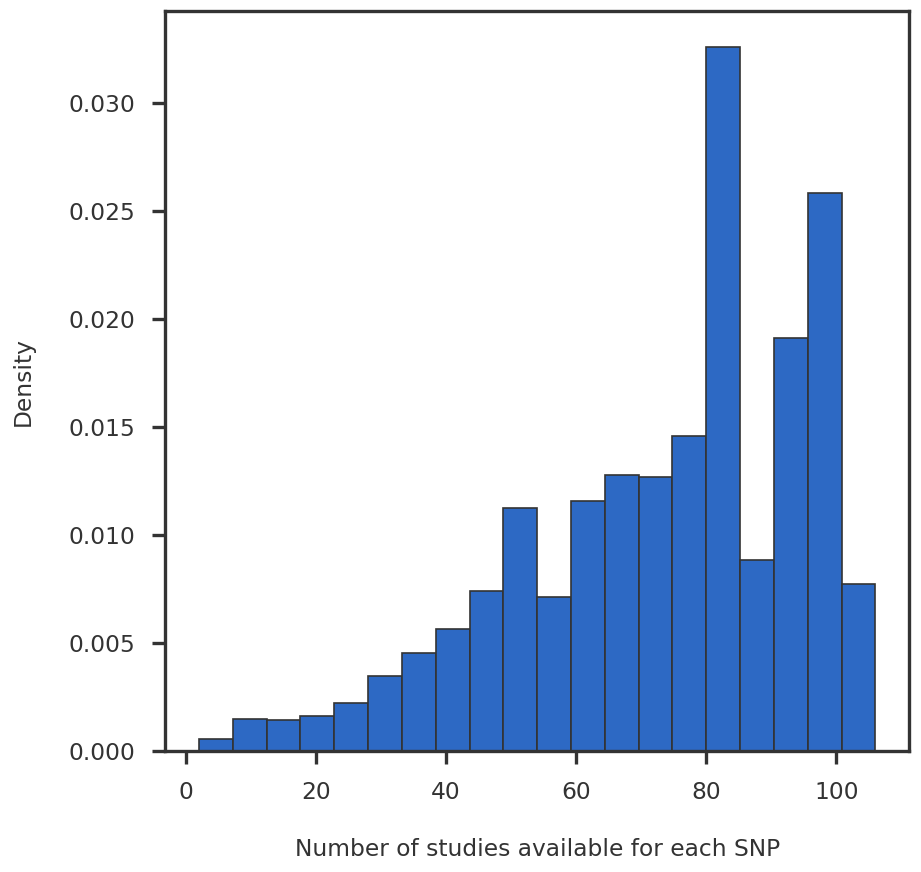

In [12]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.hist(snps_count['count'], density = True)
ax1.set_xlabel('Number of studies available for each SNP')
ax1.set_ylabel('Density')
plt.show()

In [13]:
assoc_df_fa_nsnp = snps_count[snps_count['count'] >=20 ].merge(assoc_df_fa, on=['SNP'], how='inner').filter(regex = '^(?!.*count)', axis = 1)
assoc_df_fa_nsnp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625305 entries, 0 to 625304
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   SNP     625305 non-null  string 
 1   A1      625305 non-null  string 
 2   A2      625305 non-null  string 
 3   CHR     611812 non-null  string 
 4   BP      611812 non-null  Int64  
 5   Z       175388 non-null  float64
 6   P       625305 non-null  float64
 7   BETA    625305 non-null  float64
 8   SE      625290 non-null  float64
 9   ID      625305 non-null  string 
 10  TRAIT   625305 non-null  string 
dtypes: Int64(1), float64(4), string(6)
memory usage: 53.1 MB


### Remove duplicate (SNP, ID) combinations

In [14]:
assoc_df_fa_nsnp_nodup = assoc_df_fa_nsnp.drop_duplicates(subset=['SNP', 'ID'], keep = False)
assoc_df_fa_nsnp_nodup.info()

<class 'pandas.core.frame.DataFrame'>
Index: 625283 entries, 0 to 625304
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   SNP     625283 non-null  string 
 1   A1      625283 non-null  string 
 2   A2      625283 non-null  string 
 3   CHR     611790 non-null  string 
 4   BP      611790 non-null  Int64  
 5   Z       175388 non-null  float64
 6   P       625283 non-null  float64
 7   BETA    625283 non-null  float64
 8   SE      625268 non-null  float64
 9   ID      625283 non-null  string 
 10  TRAIT   625283 non-null  string 
dtypes: Int64(1), float64(4), string(6)
memory usage: 57.8 MB


In [15]:
assoc_df_fa_nsnp_nodup

,SNP,A1,A2,CHR,BP,Z,P,BETA,SE,ID,TRAIT
0,rs9360322,A,G,chr6,68220736,2.121940,0.033843,0.004764,0.002245,UKB_1160_Sleep_duration,UKB_1160_Sleep_duration
1,rs9360322,A,G,chr6,68220736,0.247038,0.804878,0.000706,0.002858,UKB_1180_Morning_or_evening_person_chronotype,UKB_1180_Morning_or_evening_person_chronotype
2,rs9360322,A,G,chr6,68220736,0.451971,0.651290,0.000942,0.002084,UKB_1200_Sleeplessness_or_insomnia,UKB_1200_Sleeplessness_or_insomnia
3,rs9360322,A,G,chr6,68220736,-0.556452,0.577902,-0.000050,0.000090,UKB_20002_1243_self_reported_psychological_or_...,UKB_20002_1243_self_reported_psychological_or_...
4,rs9360322,A,G,chr6,68220736,-0.682461,0.494947,-0.000084,0.000123,UKB_20002_1262_self_reported_parkinsons_disease,UKB_20002_1262_self_reported_parkinsons_disease
...,...,...,...,...,...,...,...,...,...,...,...
625300,rs144129573,C,T,12,114922944,NaN,0.145900,0.060305,0.041500,ieu-b-41,bipolar disorder
625301,rs144129573,C,T,12,114922944,NaN,0.886100,-0.012002,0.084000,ieu-a-806,Autism
625302,rs144129573,C,T,12,114922944,NaN,0.545700,-0.050200,0.083000,ieu-b-7,Parkinson's disease
625303,rs144129573,C,T,12,114922944,NaN,0.145900,-0.060305,0.041500,daner_PGC_BIP32b_mds7a_0416a.txt.gz,daner_PGC_BIP32b_mds7a_0416a.txt.gz


# Data Matrix

In [16]:
beta_df = assoc_df_fa_nsnp_nodup[['SNP', 'ID', 'BETA']].pivot(index = 'SNP', columns = 'ID', values = 'BETA').fillna(0).rename_axis(None, axis = 0).rename_axis(None, axis = 1)
se_df   = assoc_df_fa_nsnp_nodup[['SNP', 'ID', 'SE']].pivot(index = 'SNP', columns = 'ID', values = 'SE').rename_axis(None, axis = 0).rename_axis(None, axis = 1)
prec_df = se_df.apply(lambda x: 1 / x / x).fillna(0)

In [17]:
beta_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8403 entries, rs1000031 to rs999494
Columns: 108 entries, AD_sumstats_Jansenetal_2019sept.txt.gz to pts_all_freeze2_overall.txt.gz
dtypes: float64(108)
memory usage: 7.0 MB


In [18]:
pd.testing.assert_index_equal(beta_df.index, prec_df.index)
pd.testing.assert_index_equal(beta_df.columns, prec_df.columns)

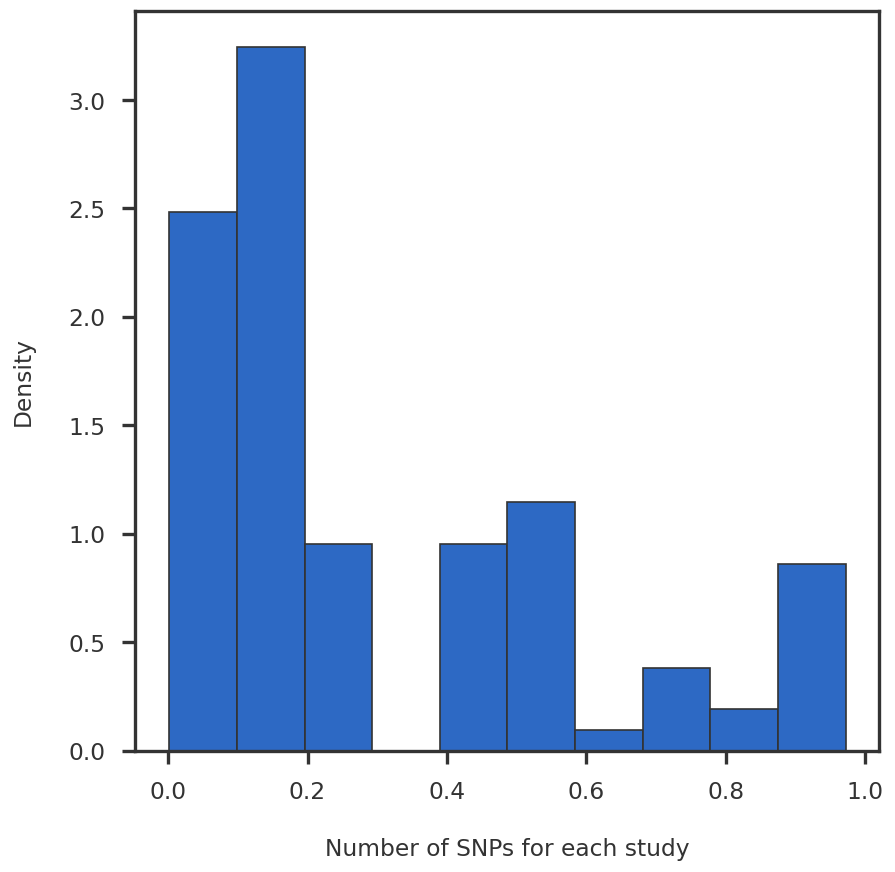

In [19]:
missing_df = pd.DataFrame(prec_df == 0).mean(axis = 0).reset_index(name = 'missingness').rename(columns = {'index': 'ID'})

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.hist(missing_df['missingness'], density = True, bins = 10)
ax1.set_xlabel('Number of SNPs for each study')
ax1.set_ylabel('Density')
plt.show()

In [20]:
keep_columns = missing_df[missing_df['missingness'] < 0.5]['ID'].to_list()
print(f"Keeping {len(keep_columns)} phenotypes with low missingness")

beta_df_sub = beta_df[keep_columns]
prec_df_sub = prec_df[keep_columns]

Keeping 80 phenotypes with low missingness


In [21]:
beta_df_sub.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8403 entries, rs1000031 to rs999494
Data columns (total 80 columns):
 #   Column                                                                                            Non-Null Count  Dtype  
---  ------                                                                                            --------------  -----  
 0   AD_sumstats_Jansenetal_2019sept.txt.gz                                                            8403 non-null   float64
 1   CNCR_Insomnia_all                                                                                 8403 non-null   float64
 2   ENIGMA_Intracraneal_Volume                                                                        8403 non-null   float64
 3   IGAP_Alzheimer                                                                                    8403 non-null   float64
 4   Jones_et_al_2016_Chronotype                                                                       8403 non-null   float

# Save Pickle

In [23]:
beta_df_filename = f"{data_dir}/beta_df.pkl"
prec_df_filename = f"{data_dir}/prec_df.pkl"
beta_df_sub.to_pickle(beta_df_filename)
prec_df_sub.to_pickle(prec_df_filename)